In [1]:
import gym
import CustomGymEnvs
import torchgraphs as tg
import torch
import torch.nn as nn

from collections import OrderedDict

In [2]:
env = gym.make("FetchReachEnv-v0")

In [3]:
num_nodes = env.observation_space['observation_nodes'].shape[0]
num_edges = env.observation_space['observation_edges'].shape[0]

In [85]:
# g1 = tg.GraphBatch(
#     node_features=torch.FloatTensor(env.robot_graph.node_features),
#     edge_features=torch.FloatTensor(env.robot_graph.edge_features),
#     senders=torch.tensor(env.robot_graph.edges_from),
#     receivers=torch.tensor(env.robot_graph.edges_to),
#     global_features=torch.randn([1, 10]),
#     num_nodes_by_graph=torch.tensor([num_nodes]),
#     num_edges_by_graph=torch.tensor([num_edges])
# )

g1 = tg.Graph(
    node_features=torch.FloatTensor(env.robot_graph.node_features),
    edge_features=torch.FloatTensor(env.robot_graph.edge_features),
    senders=torch.tensor(env.robot_graph.edges_from),
    receivers=torch.tensor(env.robot_graph.edges_to),
    global_features=torch.randn([1, 10])
)

In [86]:
# g2 = tg.GraphBatch(
#     node_features=torch.FloatTensor(env.robot_graph.node_features),
#     edge_features=torch.FloatTensor(env.robot_graph.edge_features),
#     senders=torch.tensor(env.robot_graph.edges_from),
#     receivers=torch.tensor(env.robot_graph.edges_to),
#     global_features=torch.randn([1, 10]),
#     num_nodes_by_graph=torch.tensor([num_nodes]),
#     num_edges_by_graph=torch.tensor([num_edges])
# )

g2 = tg.Graph(
    node_features=torch.FloatTensor(env.robot_graph.node_features),
    edge_features=torch.FloatTensor(env.robot_graph.edge_features),
    senders=torch.tensor(env.robot_graph.edges_from),
    receivers=torch.tensor(env.robot_graph.edges_to),
    global_features=torch.randn([1, 10]),
)

In [6]:
dataloader = torch.utils.data.DataLoader([g1, g2], collate_fn=tg.GraphBatch.collate)

In [94]:
a = tg.GraphBatch.collate([g1, g2])

In [99]:
a.global_features = torch.randn([2, 10])

In [101]:
a.global_features.shape

torch.Size([2, 10])

In [79]:
class QNetwork(nn.Module):
    def __init__(self, num_node_features, num_edge_features, num_actions):
        # For the action value function, we consider the action as the graph's global features
        super(QNetwork, self).__init__()
        
        self.edge1 = tg.EdgeLinear(256,
                                   edge_features=num_edge_features,
                                   sender_features=num_node_features,
                                   receiver_features=num_node_features,
                                   global_features=num_actions)
        self.edge_relu1 = tg.EdgeReLU()

        self.node1 = tg.NodeLinear(256,
                                   node_features=num_node_features,
                                   incoming_features=256,
                                   global_features=num_actions,
                                   aggregation='avg')
        self.node_relu1 = tg.NodeReLU()

        self.global1 = tg.GlobalLinear(int(num_actions / 2),
                                       node_features=256,
                                       edge_features=256,
                                       global_features=num_actions,
                                       aggregation='avg')
        self.global_relu = tg.GlobalReLU()

        self.edge2 = tg.EdgeLinear(128,
                                   edge_features=256,
                                   sender_features=256,
                                   receiver_features=256,
                                   global_features=int(num_actions / 2))
        self.edge_relu2 = tg.EdgeReLU()

        self.node2 = tg.NodeLinear(128,
                                   node_features=256,
                                   incoming_features=128,
                                   global_features=int(num_actions / 2),
                                   aggregation='avg')
        self.node_relu2 = tg.NodeReLU()

        self.global_output = tg.GlobalLinear(1,
                                             node_features=128,
                                             edge_features=128,
                                             global_features=int(num_actions / 2),
                                             aggregation='avg')

    def forward(self, g):
        print(g)
        g = self.edge_relu1(self.edge1(g))
        print(g)
        g = self.node_relu1(self.node1(g))
        print(g)
        g = self.global_relu(self.global1(g))
        print(g)
        g = self.edge_relu2(self.edge2(g))
        print(g)
        g = self.node_relu2(self.node2(g))
        print(g)
        return self.global_output(g)

In [80]:
q = QNetwork(g1.node_features_shape[0], g1.edge_features_shape[0], 10)

In [83]:
# q(tg.GraphBatch.collate((g1, g2)))
q(g1).global_features

GraphBatch(#1, n=tensor([28]), e=tensor([27]), n_shape=torch.Size([14]), e_shape=torch.Size([10]), g_shape=torch.Size([10]))
GraphBatch(#1, n=tensor([28]), e=tensor([27]), n_shape=torch.Size([14]), e_shape=torch.Size([256]), g_shape=torch.Size([10]))
GraphBatch(#1, n=tensor([28]), e=tensor([27]), n_shape=torch.Size([256]), e_shape=torch.Size([256]), g_shape=torch.Size([10]))
GraphBatch(#1, n=tensor([28]), e=tensor([27]), n_shape=torch.Size([256]), e_shape=torch.Size([256]), g_shape=torch.Size([5]))
GraphBatch(#1, n=tensor([28]), e=tensor([27]), n_shape=torch.Size([256]), e_shape=torch.Size([128]), g_shape=torch.Size([5]))
GraphBatch(#1, n=tensor([28]), e=tensor([27]), n_shape=torch.Size([128]), e_shape=torch.Size([128]), g_shape=torch.Size([5]))


tensor([[1.7000]], grad_fn=<AddBackward0>)

In [26]:
rb = ReplayMemory(30, 0)

for _ in range(20):
    g = tg.Graph(
        node_features=torch.tensor(env.robot_graph.node_features),
        edge_features=torch.tensor(env.robot_graph.edge_features),
        senders=torch.tensor(env.robot_graph.edges_from),
        receivers=torch.tensor(env.robot_graph.edges_to),
    )
    rb.push(g, 1, 2, g, False)

In [6]:
torch.cat((torch.rand([256, 6]), torch.rand([256, 1])), 1).shape

torch.Size([256, 7])

In [1]:
a = {'a': 1, 'b': 2, 'c': 3}

In [6]:
import numpy as np
np.array(list(a.values())) / 2

array([0.5, 1. , 1.5])

In [1]:
import numpy as np

In [17]:
arr = np.empty([0, 5])

In [20]:
arr2 = np.append(arr, [[0,1,2,3,4]], axis=0)

In [22]:
np.append(arr2, np.arange(5, 10).reshape(1, 5), axis=0)

array([[0., 1., 2., 3., 4.],
       [5., 6., 7., 8., 9.]])

In [31]:
import pandas as pd

pd.read_csv('/home/mehran/Documents/SAC_GCN/Data/FetchReachEnv-v0/standard/seed0/eval.csv')

,num_episodes,num_steps,num_updates,eval_reward
0,10.0,500.0,243.0,-10.249750
1,20.0,1000.0,743.0,-6.389949
2,30.0,1500.0,1243.0,-8.711387
3,40.0,2000.0,1743.0,-6.880497
4,50.0,2500.0,2243.0,-7.790122
5,60.0,3000.0,2743.0,-7.270830
6,70.0,3500.0,3243.0,-6.690151
7,80.0,4000.0,3743.0,-7.699853


In [2]:
d = [1,2,3,4]
d += [4,5,6,7]

In [1]:
import torch

In [3]:
model = torch.load('Data/HalfCheetahEnv-v0/standard/seed0/model')

In [8]:
model['policy_state_dict']['mean_linear.W_global'].shape

torch.Size([6, 128])

In [1]:
import numpy as np

In [10]:
np.linspace(1, 100, 100)

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100.])

In [5]:
a = np.array([1,2,3])
b = np.arange(5)

In [16]:
np.concatenate([a, b])

array([1, 2, 3, 0, 1, 2, 3, 4])

In [21]:
import os
from pathlib import Path
os.path.abspath(__file__)

NameError: name '__file__' is not defined

In [3]:
import numpy as np

In [4]:
np.zeros([13])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [1]:
a = {'b':2, 'a':1, 'c':0}

In [6]:
isinstance([1,2,3,4], list)

True

In [8]:
a['d'] = None

In [10]:
a['d']

In [18]:
[x for i in np.arange(10) for x in [i ** 2, i **3]]


[0, 0, 1, 1, 4, 8, 9, 27, 16, 64, 25, 125, 36, 216, 49, 343, 64, 512, 81, 729]

In [7]:
''.join(['a', 'b', 'c'])

SyntaxError: EOL while scanning string literal (4089098238.py, line 1)

In [4]:
d = [1,2,3,4]
list.reverse(d)


In [1]:
import numpy as np
a = np.arange(100).reshape([4, 5, 5])

In [8]:
import matplotlib.pyplot as plt

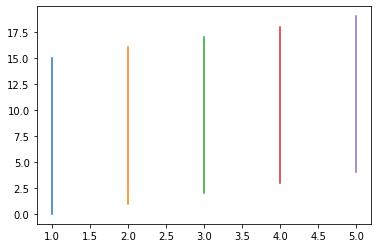

In [20]:
a = np.arange(20).reshape([4, 5])
x = np.ones_like(a) * np.linspace(1, 5, 5)
plt.plot(x, a)

In [24]:
import seaborn as sns
import itertools

In [25]:
palette = itertools.cycle(sns.color_palette())

In [31]:
i = 10
for c in iter(palette):
    print(c)
    if i == 0:
        break
    else:
        i-=1 

(1.0, 0.4980392156862745, 0.054901960784313725)
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
(0.5803921568627451, 0.403921568627451, 0.7411764705882353)
(0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
(0.8901960784313725, 0.4666666666666667, 0.7607843137254902)
(0.4980392156862745, 0.4980392156862745, 0.4980392156862745)
(0.7372549019607844, 0.7411764705882353, 0.13333333333333333)
(0.09019607843137255, 0.7450980392156863, 0.8117647058823529)
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
(1.0, 0.4980392156862745, 0.054901960784313725)


In [38]:
a = np.arange(100).reshape(10, 10)

In [39]:
a / np.max(a, axis=1)

array([[ 0.        ,  0.05263158,  0.06896552,  0.07692308,  0.08163265,
         0.08474576,  0.08695652,  0.08860759,  0.08988764,  0.09090909],
       [ 1.11111111,  0.57894737,  0.4137931 ,  0.33333333,  0.28571429,
         0.25423729,  0.23188406,  0.21518987,  0.20224719,  0.19191919],
       [ 2.22222222,  1.10526316,  0.75862069,  0.58974359,  0.48979592,
         0.42372881,  0.37681159,  0.34177215,  0.31460674,  0.29292929],
       [ 3.33333333,  1.63157895,  1.10344828,  0.84615385,  0.69387755,
         0.59322034,  0.52173913,  0.46835443,  0.42696629,  0.39393939],
       [ 4.44444444,  2.15789474,  1.44827586,  1.1025641 ,  0.89795918,
         0.76271186,  0.66666667,  0.59493671,  0.53932584,  0.49494949],
       [ 5.55555556,  2.68421053,  1.79310345,  1.35897436,  1.10204082,
         0.93220339,  0.8115942 ,  0.72151899,  0.65168539,  0.5959596 ],
       [ 6.66666667,  3.21052632,  2.13793103,  1.61538462,  1.30612245,
         1.10169492,  0.95652174,  0.84810127

In [40]:
a

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

In [42]:
np.max(a, axis=0)

array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [2]:
import numpy as np
a = np.zeros([5, 6])

In [7]:
a = np.append(a, [np.arange(6)], axis=0)

In [8]:
a

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 1., 2., 3., 4., 5.]])

In [1]:
import pandas as pd

In [16]:
pd.read_csv('/home/mehran/Documents/SAC_GCN_data/HalfCheetahEnvGraph-v0/standard/seed5/train.csv')

,num_episodes,num_steps,num_updates,episode_steps,train_reward
0,1.0,1000.0,743.0,1000.0,-403.180309
1,2.0,2000.0,1743.0,1000.0,-212.655589
2,3.0,3000.0,2743.0,1000.0,-226.291596
3,4.0,4000.0,3743.0,1000.0,-268.514779
4,5.0,5000.0,4743.0,1000.0,-357.543135
...,...,...,...,...,...
1995,1996.0,1996000.0,1995743.0,1000.0,8540.532494
1996,1997.0,1997000.0,1996743.0,1000.0,8677.457915
1997,1998.0,1998000.0,1997743.0,1000.0,8586.880017
1998,1999.0,1999000.0,1998743.0,1000.0,8743.468819


<AxesSubplot:>

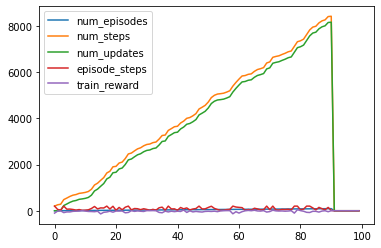

In [18]:
pd.read_csv('/home/mehran/Documents/SAC_GCN/Data/AntEnvGraph-v0/standard/seed0/train.csv')

In [2]:
d = ['hello', 'apple']
d.remove('apple')

In [5]:
d.remove(None)

ValueError: list.remove(x): x not in list

In [1]:
for i in range(0,10):
    print(i)

0
1
2
3
4
5
6
7
8
9


In [5]:
import numpy as np
a = np.zeros([10, 2])
a[:1]

array([[0., 0.]])